In [50]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#libraries
import pandas as pd
import numpy as np
from datetime import date

# Visualizing
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
#Visual format
pd.options.display.float_format = '{:20,.4f}'.format

#my libraries
from wrangle import get_zillow_data, wrangle_zillow, remove_outliers, train_validate_test_split, get_hist, get_box, summarize
from explore import inertia, variable_distributions, plot_against_target
import evaluate
import model
import env

#library imports
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

# Statistical Tests
import scipy.stats as stats

#alpha
alpha = .05

ImportError: cannot import name 'summarize' from 'wrangle' (/Users/hector/codeup-data-science/zestimate_error_drivers_project/wrangle.py)

# Executive Summary

- Continuing with the Zillow 2017 properties and predictions for single unit family homes I am looking for what is driving the errors in the Zestimates.

- Of the five tested features against, log error is dependent of age and sqft.

- Through exploration and statistical testing I found homes over 50, homes with less than 1000 sqft, and ... are the biggest drivers of errors.

- In feature engineering my model did do better then the baseline; however, modeling my data with a baseline of ... my test data came back with an RMSE of ....

- What I would like to test is exactly where the highest amount of the homes are located.



## Plan

- My plan is to take the 2017 properties and predictions through the data pipeline in order to find log error drivers and prepare a model to predict future errors.

- Select the <a href="https://trello.com/invite/b/EMEzPn69/2f064c89555d288b2b4b55618ceaceab/clusteringproject">link</a> to find a copy of my trello board I used in planning and executing this project.

- Objectives:
    - Is a higher log error dependent on homes over 50 years old? (Cluster - 2)
    - Is a higher log error dependent on homes less 1000 sqft? (Cluster - 6)
    - Is a higher log error dependent on homes who's ppsqft is less 200? (Cluster - 7)
    - Is a higher log error dependent on homes with a smaller lot size? (Cluster - 8)
    - Is a higher log error dependent on less expensive homes? (Cluster - 9)

## Acquired

- I acquired the data via MySQL, importing all tables (LEFT JOIN), sub query DISTINCT id from 2017 properties, WHERE statement for 2017% from the predictions table and where latitude iS NOT NULL 

In [2]:
df = get_zillow_data()
df.head(2)

,parcelid,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,basementsqft,...,id,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,261.0000,NaN,NaN,NaN,NaN,1727539,NaN,...,0,0.0256,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,261.0000,NaN,NaN,NaN,NaN,1387261,NaN,...,1,0.0556,2017-01-01,None,None,None,None,Single Family Residential,None,None


In [ ]:
summarize()

## Prepared

In [3]:
df = wrangle_zillow(df)
df.head(2)

,bathrooms,bedrooms,sqft,county_code,latitude,longitude,lot_size,tax_value,logerror,county,age,tax_rate,price_per_sqft,abs_logerror
0,3,4,3100,6059,"33,634,931.0000","-117,869,207.0000",4506,1023282,0.0256,Orange,23,0.0108,330,0.0256
1,1,2,1465,6111,"34,449,266.0000","-119,281,531.0000",12647,464000,0.0556,Ventura,54,0.0122,316,0.0556


### Split

In [4]:
train, validate, test = train_validate_test_split(df)
print("train observations by shape: ", train.shape)
print("validate observations by shape: ", validate.shape)
print("test observations by shape: ", test.shape)

train observations by shape:  (39960, 14)
validate observations by shape:  (17127, 14)
test observations by shape:  (14272, 14)


## Explore

##### Train variable distributions

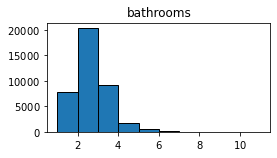

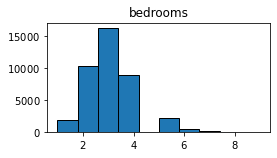

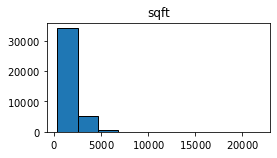

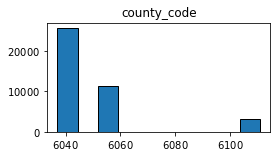

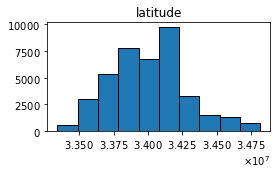

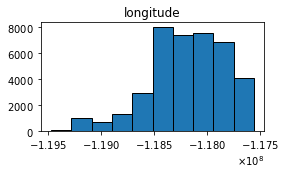

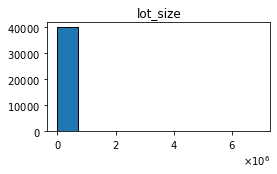

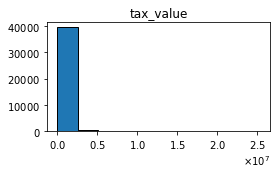

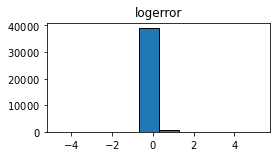

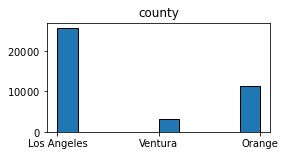

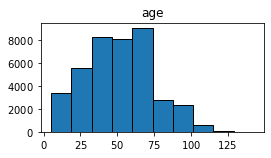

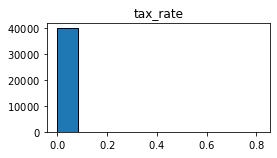

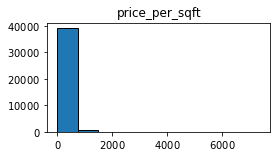

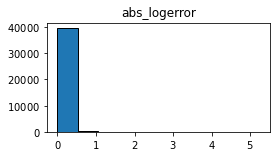

In [5]:
variable_distributions(train)

##### Log error distributions

In [6]:
variables = ['bathrooms', 'bedrooms', 'sqft', 'latitude', 
            'longitude', 'lot_size', 'tax_value', 'age', 
            'tax_rate', 'price_per_sqft', 'county_code']

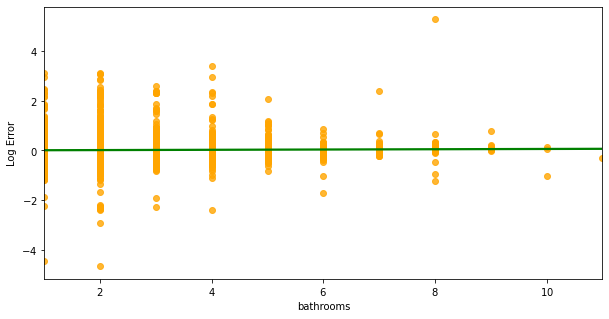

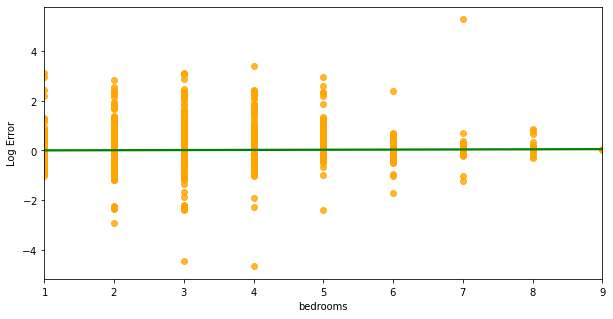

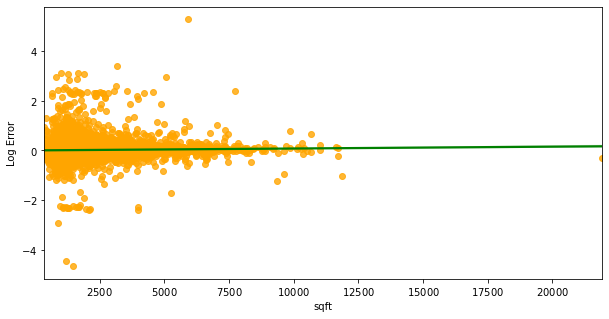

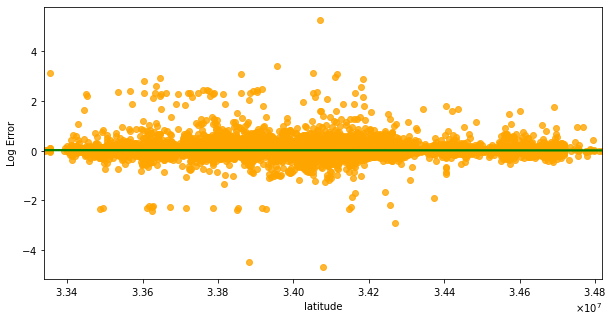

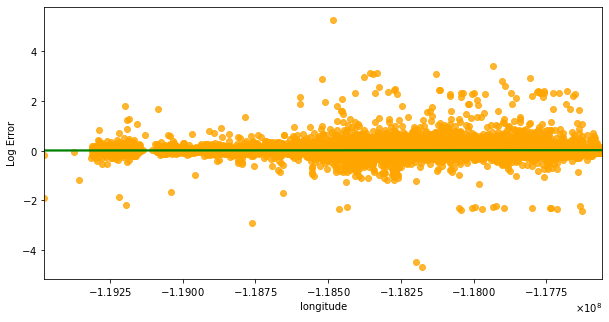

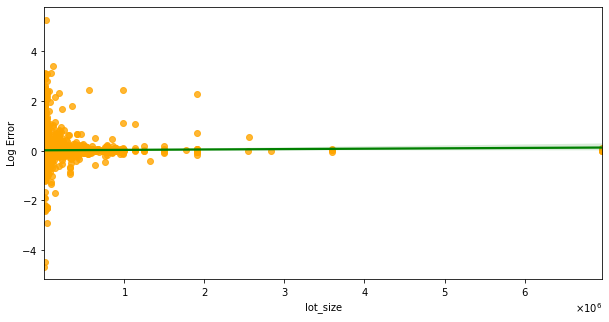

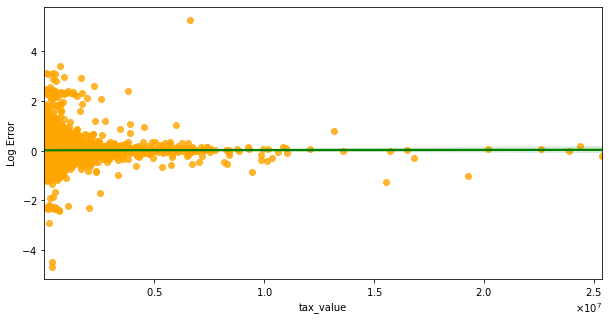

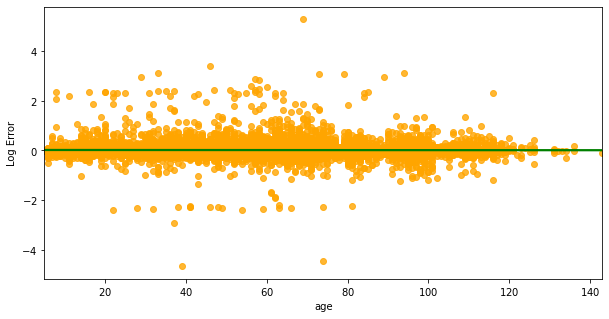

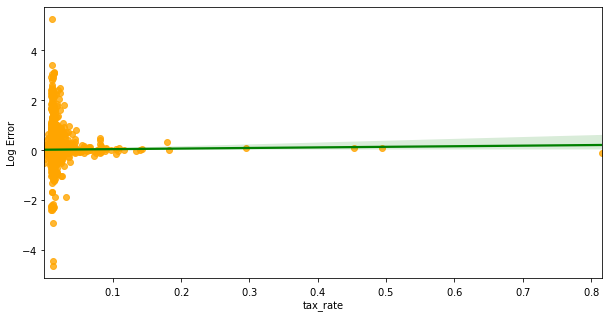

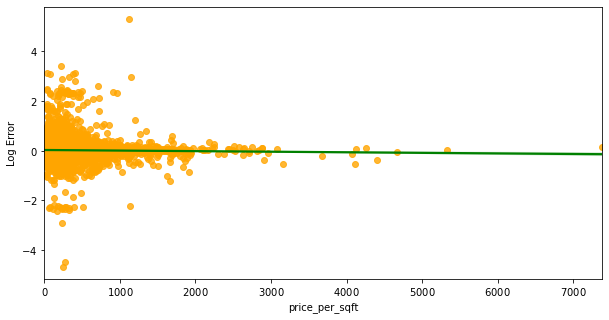

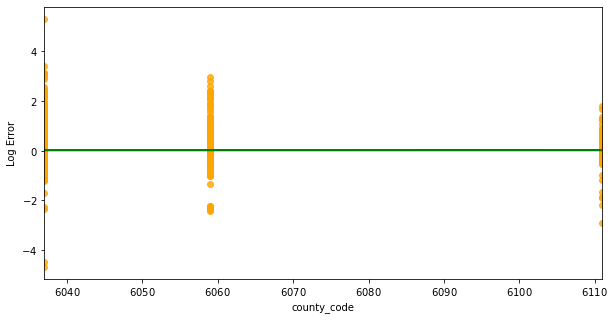

In [7]:
plot_against_target(train, target = 'logerror', var_list = variables)

<AxesSubplot:xlabel='county', ylabel='logerror'>

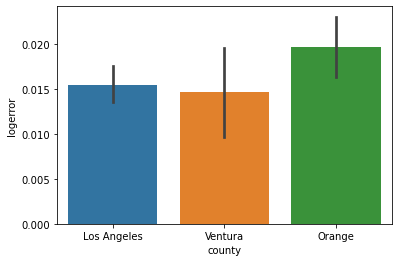

In [8]:
sns.barplot(x="county", y="logerror", data=train)

### Clustering

#### Scale

In [9]:
#empty copies to retain the original splits
train_scaled = train.copy()
validate_scaled = validate.copy()
test_scaled = test.copy()
#scale
scaler = MinMaxScaler()
#drop object column
cols = train.drop(columns=["county"]).columns.tolist()
#fit scaled data
train_scaled[cols] = scaler.fit_transform(train[cols])
validate_scaled[cols] = scaler.fit_transform(validate[cols])
test_scaled[cols] = scaler.fit_transform(test[cols])
#add object column back to the split dataframes
train_scaled["county"] = train.county.copy()
validate_scaled["county"] = validate.county.copy()
test_scaled["county"] = test.county.copy()

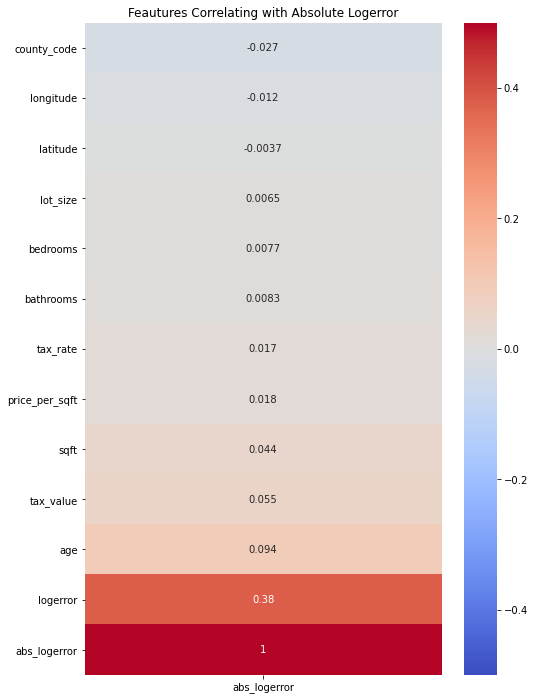

In [10]:
#create heatmap with scaled data
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(train.corr()[['abs_logerror']].sort_values(by='abs_logerror', ascending=True), 
                            cmap='coolwarm', vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with Absolute Logerror')
plt.show()

#### Cluster 1: Latitude and longitude clusters

In [11]:
X = train_scaled[['latitude', 'longitude']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['latitude', 'longitude'].mean()

,latitude,longitude
cluster,,
0,0.8685,0.7005
1,0.4388,0.6805
2,0.2349,0.8715
3,0.6083,0.4193


Text(0.5, 1.0, 'Visualizing Cluster Centers')

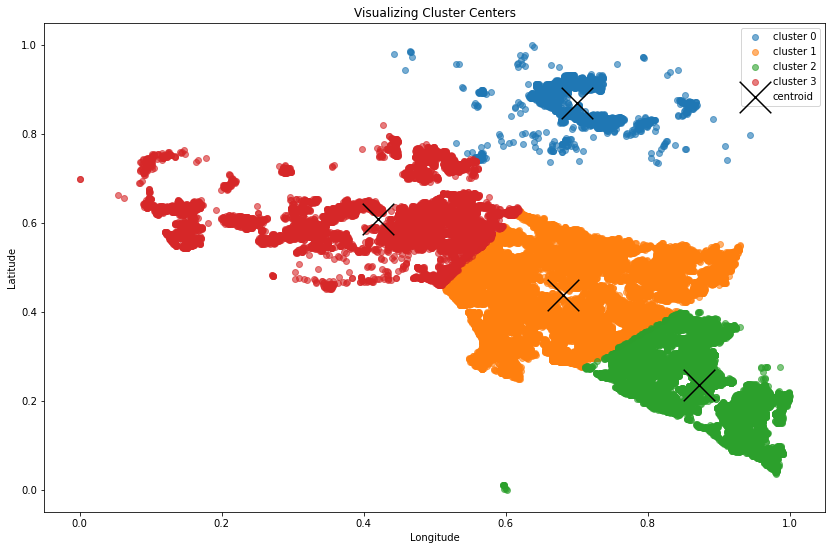

In [12]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.longitude, subset.latitude, label='cluster ' + str(cluster), alpha=.6)
centroids.plot.scatter(y='latitude', x='longitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualizing Cluster Centers')

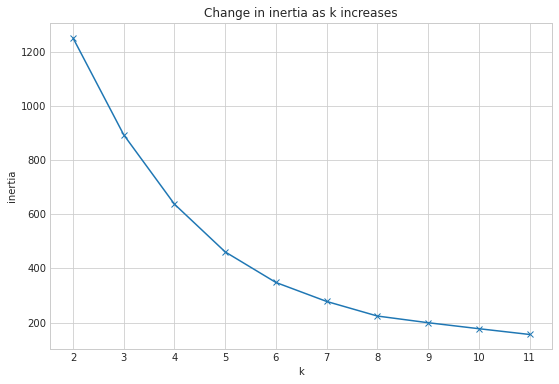

In [13]:
inertia(X)

#### Cluster 2: Log error to age of the home clusters

In [14]:
X = train_scaled[['logerror', 'age']]
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['logerror', 'age'].mean()

,logerror,age
cluster,,
0,0.4710,0.1801
1,0.4703,0.6323
2,0.4713,0.4061


Text(0.5, 1.0, 'Visualizing Cluster Centers')

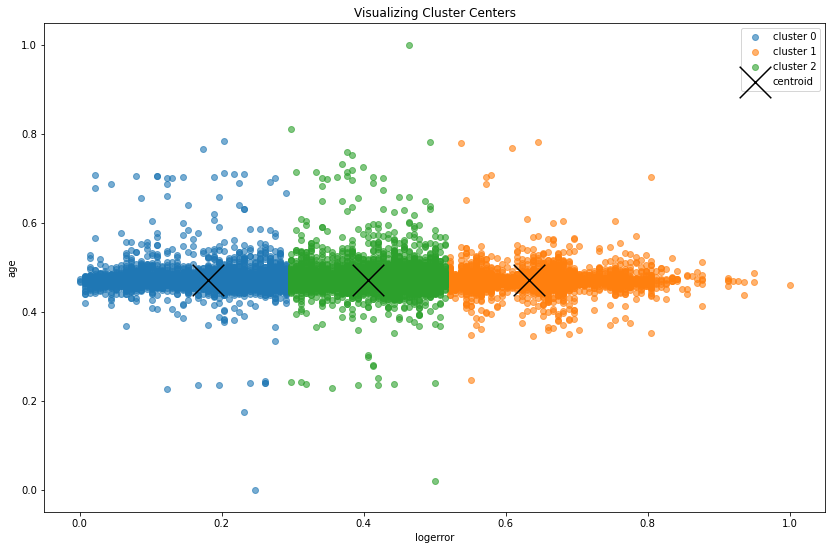

In [15]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.age, subset.logerror, label='cluster ' + str(cluster), alpha=.6)
centroids.plot.scatter(y='logerror', x='age', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('logerror')
plt.ylabel('age')
plt.title('Visualizing Cluster Centers')

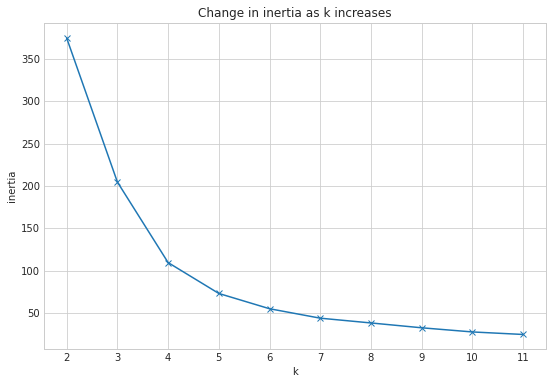

In [16]:
inertia(X)

#### Cluster 6: Log error to home square footage clusters

In [17]:
X = train_scaled[['logerror', 'sqft']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['logerror', 'sqft'].mean()

,logerror,sqft
cluster,,
0,0.4700,0.0373
1,0.4713,0.1326
2,0.6254,0.0617
3,0.4704,0.0742
4,0.4751,0.2513


Text(0.5, 1.0, 'Visualizing Cluster Centers')

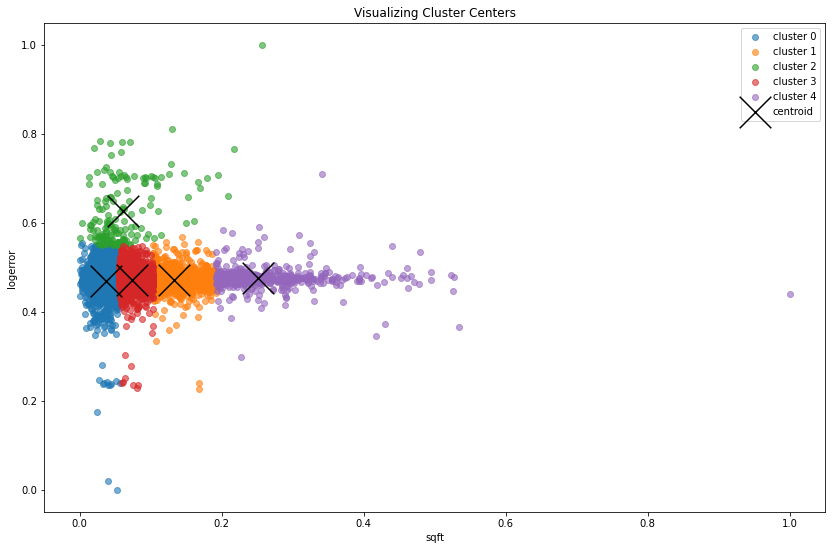

In [18]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.sqft, subset.logerror, label='cluster ' + str(cluster), alpha=.6)
centroids.plot.scatter(y='logerror', x='sqft', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('sqft')
plt.ylabel('logerror')
plt.title('Visualizing Cluster Centers')

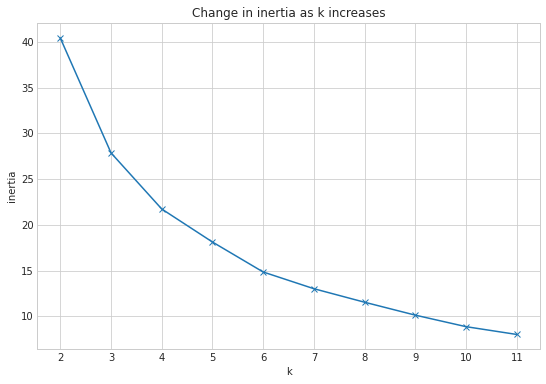

In [19]:
inertia(X)

#### Cluster 7: Log error to price per square footage clusters

In [20]:
X = train_scaled[['logerror', 'price_per_sqft']]
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['logerror', 'price_per_sqft'].mean()

,logerror,price_per_sqft
cluster,,
0,0.4697,0.0444
1,0.4691,0.0914
2,0.4708,0.0179
3,0.4666,0.2591
4,0.5889,0.0319


Text(0.5, 1.0, 'Visualizing Cluster Centers')

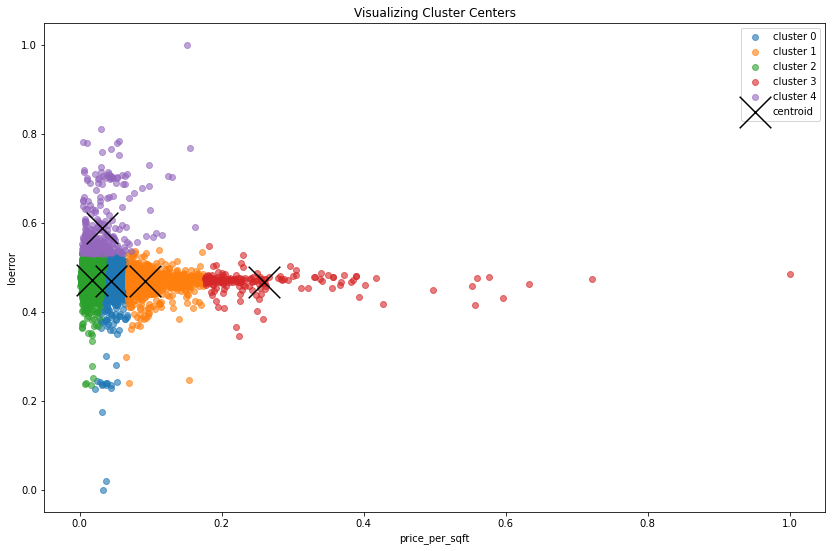

In [21]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.price_per_sqft, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='price_per_sqft', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('price_per_sqft')
plt.ylabel('loerror')
plt.title('Visualizing Cluster Centers')

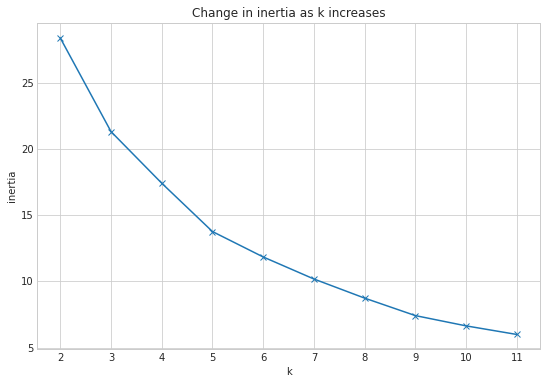

In [22]:
inertia(X)

#### Cluster 8: Log error to lot size clusters

In [23]:
X = train_scaled[['logerror', 'lot_size']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['logerror', 'lot_size'].mean()

,logerror,lot_size
cluster,,
0,0.4701,0.0028
1,0.4709,0.7844
2,0.5825,0.0052
3,0.4702,0.0805


Text(0.5, 1.0, 'Visualizing Cluster Centers')

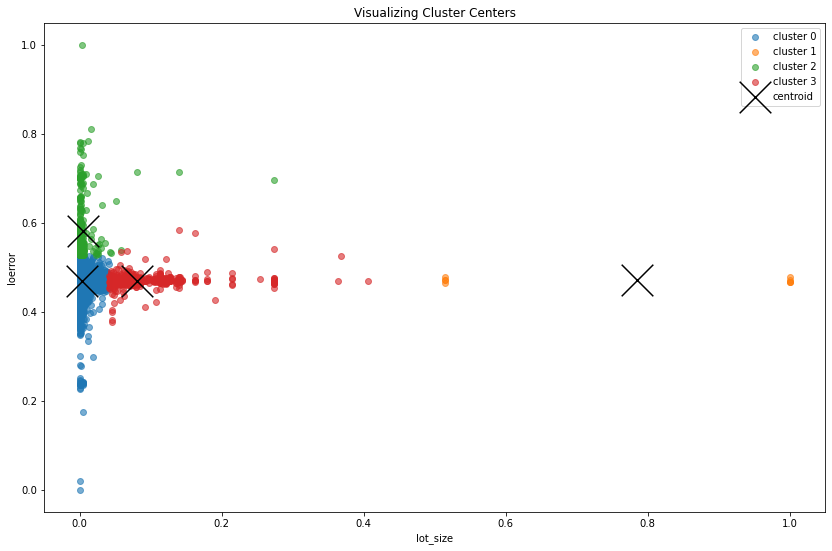

In [24]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.lot_size, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='lot_size', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('lot_size')
plt.ylabel('loerror')
plt.title('Visualizing Cluster Centers')

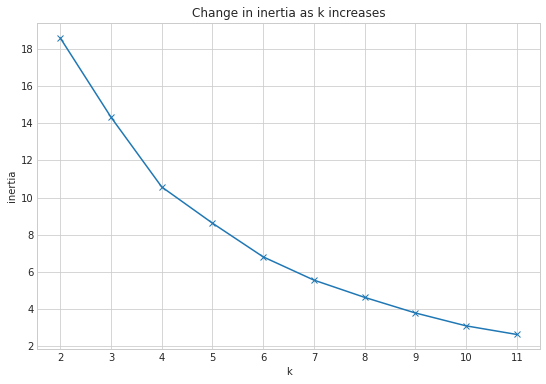

In [25]:
inertia(X)

#### Cluster 9: Log error to home value clusters

In [26]:
X = train_scaled[['logerror', 'tax_value']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
train_scaled['cluster'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
train_scaled.groupby('cluster')['logerror', 'tax_value'].mean()

,logerror,tax_value
cluster,,
0,0.4701,0.0146
1,0.4678,0.3261
2,0.4710,0.0695
3,0.5885,0.0178


Text(0.5, 1.0, 'Visualizing Cluster Centers')

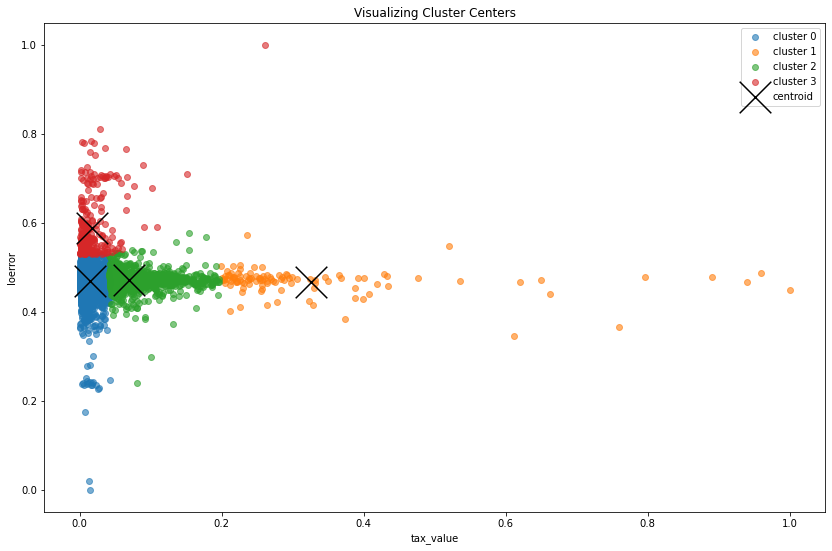

In [27]:
plt.figure(figsize=(14, 9))

for cluster, subset in train_scaled.groupby('cluster'):
    plt.scatter(subset.tax_value, subset.logerror, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='logerror', x='tax_value', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('tax_value')
plt.ylabel('loerror')
plt.title('Visualizing Cluster Centers')

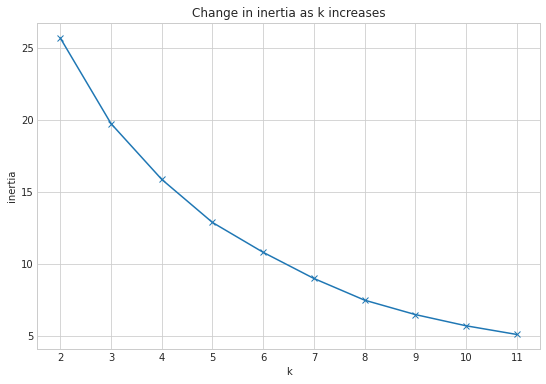

In [28]:
inertia(X)

### Takeaways 
- Is a higher log error dependent on homes over 50 years old? (Cluster - 2)
- Is a higher log error dependent on homes less 1000 sqft? (Cluster - 6)
- Is a higher log error dependent on homes who's ppsqft is less 200? (Cluster - 7)
- Is a higher log error dependent on homes with a smaller lot size? (Cluster - 8)
- Is a higher log error dependent on less expensive homes? (Cluster - 9)

### Statistical Testing

##### Is a higher log error dependent on homes over 50 years old? (Cluster - 2)

In [29]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.age > 50)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 39.8021
p     = 0.0000


We reject the null and accept the alternate: Is dependent


##### Is a higher log error dependent on homes less 1000 sqft? (Cluster - 6)

In [30]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.sqft > 1000)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 23.0525
p     = 0.0000


We reject the null and accept the alternate: Is dependent


##### Is a higher log error dependent on homes who's ppsqft is less 500? (Cluster - 7)

In [31]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.price_per_sqft < 500)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 0.3654
p     = 0.5455


We fail to reject the null and accept the null: Is independent


##### Is a higher log error dependent on homes with a smaller lot size? (Cluster - 8)

In [32]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror > 0, train.lot_size < 236)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 0.0000
p     = 1.0000


We fail to reject the null and accept the null: Is independent


##### Is a higher log error dependent on less expensive homes? (Cluster - 9)

In [33]:
Null = 'Is independent'
Alternate = 'Is dependent'

observed = pd.crosstab(train.logerror, train.tax_value)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

print('\n')
if p < alpha:
    print(f'We reject the null and accept the alternate: {Alternate}')
else:
    print(f'We fail to reject the null and accept the null: {Null}')

chi^2 = 1167313724.0498
p     = 0.0000


We reject the null and accept the alternate: Is dependent


## Model

### Feature Engineering

In [34]:
X_train = train_scaled[['age', 'bathrooms', 'bedrooms', 'sqft', 'price_per_sqft', 'lot_size', 'tax_value']]#features
y_train = train.logerror
X_validate = validate_scaled[['age', 'bathrooms', 'bedrooms', 'sqft', 'price_per_sqft', 'lot_size', 'tax_value']]#features
y_validate = validate.logerror
X_test = test_scaled[['age', 'bathrooms', 'bedrooms', 'sqft', 'price_per_sqft', 'lot_size', 'tax_value']]#features
y_test = test.logerror

In [35]:
evaluate.rfe(X_train,y_train,1)

Index(['sqft'], dtype='object')

In [36]:
evaluate.rfe(X_train,y_train,3)

Index(['sqft', 'price_per_sqft', 'lot_size'], dtype='object')

In [37]:
evaluate.select_kbest(X_train,y_train,1)

Index(['sqft'], dtype='object')

In [38]:
evaluate.select_kbest(X_train,y_train,3)

Index(['bathrooms', 'bedrooms', 'sqft'], dtype='object')

### Regression Modeling

In [39]:
#baseline function calculates baseline and adds columns to the dataframe
evaluate.get_baseline(train,train[['sqft']], train['logerror'])

,bathrooms,bedrooms,sqft,county_code,latitude,longitude,lot_size,tax_value,logerror,county,age,tax_rate,price_per_sqft,abs_logerror,yhat_baseline,yhat
35417,1,1,792,6037,"33,832,389.0000","-118,088,033.0000",10624,43391,0.0336,Los Angeles,84,0.0210,54,0.0336,0.0166,0.0094
75709,2,4,2060,6037,"33,770,099.0000","-118,103,594.0000",7693,496914,-0.0546,Los Angeles,60,0.0120,241,0.0546,0.0166,0.0189
48946,3,3,2750,6111,"34,176,273.0000","-119,221,020.0000",4121,1068000,0.0075,Ventura,40,0.0125,388,0.0075,0.0166,0.0241
3102,3,3,3412,6059,"33,630,925.0000","-117,647,902.0000",9375,850417,0.1842,Orange,42,0.0101,249,0.1842,0.0166,0.0290
4854,1,1,1013,6037,"33,765,600.0000","-118,182,000.0000",69327,310220,-0.1807,Los Angeles,29,0.0119,306,0.1807,0.0166,0.0111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31583,4,3,3324,6059,"33,900,985.0000","-117,887,039.0000",5800,709615,0.0279,Orange,23,0.0112,213,0.0279,0.0166,0.0284
24870,1,2,1217,6037,"33,882,916.0000","-118,198,985.0000",9323,187101,0.6165,Los Angeles,80,0.0149,153,0.6165,0.0166,0.0126
33566,2,3,2135,6059,"33,666,308.0000","-117,916,527.0000",6720,93341,0.0794,Orange,65,0.0167,43,0.0794,0.0166,0.0195
33858,2,2,1621,6037,"34,045,100.0000","-118,261,000.0000",83398,599719,-0.0043,Los Angeles,38,0.0124,369,0.0043,0.0166,0.0156


In [40]:
evaluate.get_residuals(train, train['logerror'])

,bathrooms,bedrooms,sqft,county_code,latitude,longitude,lot_size,tax_value,logerror,county,age,tax_rate,price_per_sqft,abs_logerror,yhat_baseline,yhat,residual,residual_baseline
35417,1,1,792,6037,"33,832,389.0000","-118,088,033.0000",10624,43391,0.0336,Los Angeles,84,0.0210,54,0.0336,0.0166,0.0094,-0.0241,-0.0170
75709,2,4,2060,6037,"33,770,099.0000","-118,103,594.0000",7693,496914,-0.0546,Los Angeles,60,0.0120,241,0.0546,0.0166,0.0189,0.0735,0.0712
48946,3,3,2750,6111,"34,176,273.0000","-119,221,020.0000",4121,1068000,0.0075,Ventura,40,0.0125,388,0.0075,0.0166,0.0241,0.0166,0.0091
3102,3,3,3412,6059,"33,630,925.0000","-117,647,902.0000",9375,850417,0.1842,Orange,42,0.0101,249,0.1842,0.0166,0.0290,-0.1551,-0.1676
4854,1,1,1013,6037,"33,765,600.0000","-118,182,000.0000",69327,310220,-0.1807,Los Angeles,29,0.0119,306,0.1807,0.0166,0.0111,0.1917,0.1973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31583,4,3,3324,6059,"33,900,985.0000","-117,887,039.0000",5800,709615,0.0279,Orange,23,0.0112,213,0.0279,0.0166,0.0284,0.0005,-0.0113
24870,1,2,1217,6037,"33,882,916.0000","-118,198,985.0000",9323,187101,0.6165,Los Angeles,80,0.0149,153,0.6165,0.0166,0.0126,-0.6039,-0.5999
33566,2,3,2135,6059,"33,666,308.0000","-117,916,527.0000",6720,93341,0.0794,Orange,65,0.0167,43,0.0794,0.0166,0.0195,-0.0600,-0.0628
33858,2,2,1621,6037,"34,045,100.0000","-118,261,000.0000",83398,599719,-0.0043,Los Angeles,38,0.0124,369,0.0043,0.0166,0.0156,0.0200,0.0209


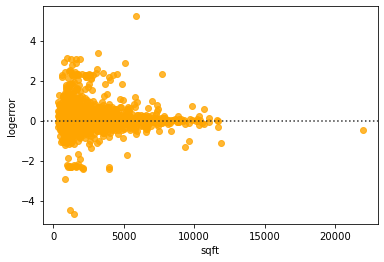

In [41]:
evaluate.plot_residual(train, train[['sqft']], train['logerror'])

In [42]:
evaluate.regression_errors(train, train['logerror'], train.yhat)

(0.027521622737870184,
 1099.7640446052926,
 1.8954852991705304,
 1101.6595299044632,
 0.1658964217150876)

In [43]:
evaluate.baseline_mean_errors(train, train['logerror'], train.yhat_baseline)

(0.027569057304916496, 1101.6595299044632, 0.1660393245737783)

In [44]:
evaluate.better_than_baseline(regression_errors = True, baseline_mean_errors = True)

The model is better then the baseline.


### Baseline Model

In [45]:
model.model_baseline(y_train, y_validate, 'logerror')

RMSE using Mean
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.16
RMSE using Median
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.16


#### Linear Regression

In [46]:
model.linear_regression(y_train, X_train, y_validate, X_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16578663674172942 
Validation/Out-of-Sample:  0.1617184772404811


#### LassoLars

In [47]:
model.lassolars(y_train, X_train, y_validate, X_validate)

RMSE for Lasso + Lars
Training/In-Sample:  0.1660393245737783 
Validation/Out-of-Sample:  0.16192107522555363


#### Tpolynomial Regression

In [48]:
model.polynomialregression(y_train, X_train, y_validate, X_validate, X_test)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.165342362537843 
Validation/Out-of-Sample:  0.7393920899205655


### Test

In [49]:
model.linear_regression_test(X_test, y_test)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1753632721829155


## Conclusion